In [15]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable

plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'


In [21]:
def RK4(
        y_n: np.ndarray,
        t_n: float,
        dt: float,
        deriv_func: Callable,
        params: dict
) -> np.ndarray:
    k1 = deriv_func(t_n, y_n, params)
    k2 = deriv_func(t_n + 0.5 * dt, y_n + 0.5 * dt * k1, params)
    k3 = deriv_func(t_n + 0.5 * dt, y_n + 0.5 * dt * k2, params)
    k4 = deriv_func(t_n + dt, y_n + dt * k3, params)

    return y_n + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)



In [23]:
def chain_derivatives(t: float, state: np.ndarray, params: dict) -> np.ndarray:
    N = params['N']
    alpha = params['alpha']
    m = params['m']

    x = state[:N+1]
    v = state[N+1:]

    # dx/dt = v
    dxdt = v.copy()

    # dv/dt = (alpha/m) * (x_{i-1} - 2x_i + x_{i+1})
    # Obliczamy tylko dla atomów wewnętrznych (1 do N-1)
    dvdt = np.zeros_like(v)

    # Wektoryzacja obliczeń dla i=1..N-1
    # x_left = x[0:-2], x_center = x[1:-1], x_right = x[2:]
    dvdt[1:-1] = (alpha / m) * (x[:-2] - 2 * x[1:-1] + x[2:])

    # Warunki brzegowe: atomy 0 i N są nieruchome (dv/dt = 0, dx/dt = 0 wymuszone przez v=0 na starcie)
    dxdt[0] = 0
    dxdt[N] = 0
    dvdt[0] = 0
    dvdt[N] = 0

    return np.concatenate([dxdt, dvdt])

def calculate_energy(x: np.ndarray, v: np.ndarray, params: dict) -> Tuple[float, float]:
    N = params['N']
    m = params['m']
    alpha = params['alpha']
    Delta = params['Delta']

    # Energia kinetyczna: T = sum(m * v^2 / 2)
    T = 0.5 * m * np.sum(v**2)

    # Energia potencjalna: U = sum(alpha/2 * (x_{i-1} - x_i + Delta)^2)
    # Suma od i=1 do N
    diffs = x[:-1] - x[1:] + Delta
    U = 0.5 * alpha * np.sum(diffs**2)

    return T, U

def solve_atomic_chain():
    params = {
        'N': 50,
        'dt': 0.02,
        'Delta': 0.1,
        'alpha': 1.0,
        'm': 1.0,
        'Nt': 5000,
        'sigma': 0.5  # Szacowana wartość na podstawie wykresu
    }

    N = params['N']
    x_max = N * params['Delta']
    x_L = x_max / 4.0
    x_R = 3 * x_max / 4.0

    # Położenia równowagi x_{i,0} = i * Delta
    x0_eq = np.array([i * params['Delta'] for i in range(N + 1)])

    # Warunek początkowy - zaburzenie gaussowskie
    x_init = x0_eq.copy()
    delta_amp = params['Delta'] / 3.0

    # Aplikacja zaburzenia dla i=1..N-1
    for i in range(1, N):
        term1 = np.exp(-((x0_eq[i] - x_L)**2) / (2 * params['sigma']**2))
        term2 = np.exp(-((x0_eq[i] - x_R)**2) / (2 * params['sigma']**2))
        x_init[i] += delta_amp * (term1 - term2)

    v_init = np.zeros(N + 1) # [cite: 48]

    state = np.concatenate([x_init, v_init])

    t_array = np.arange(params['Nt']) * params['dt']
    E_kin = np.zeros(params['Nt'])
    E_pot = np.zeros(params['Nt'])
    deviations = np.zeros((params['Nt'], N + 1))

    for i, t in enumerate(t_array):
        current_x = state[:N+1]
        current_v = state[N+1:]

        T, U = calculate_energy(current_x, current_v, params)
        E_kin[i] = T
        E_pot[i] = U

        deviations[i, :] = current_x - x0_eq

        # Krok RK4
        if i < params['Nt'] - 1:
            state = RK4(state, t, params['dt'], chain_derivatives, params)

    # Wykres 1: Energie (En.png) [cite: 51]
    plt.figure(figsize=(10, 6))
    plt.plot(t_array, E_kin + E_pot, 'k-', linewidth=2, label='Energia całkowita')
    plt.plot(t_array, E_kin, 'b--', label='Energia kinetyczna')
    plt.plot(t_array, E_pot, 'r:', label='Energia potencjalna')
    plt.xlabel('Czas t=i*dt')
    plt.ylabel('Energia')
    plt.legend(loc='lower left')
    plt.title('Zmiany energii w czasie')
    plt.tight_layout()
    plt.show()


    # Wykres 2: Mapa wychyleń (Fig1.png) [cite: 52]
    plt.figure(figsize=(10, 7))
    # Używamy imshow z extent, aby osie miały fizyczne jednostki
    # deviations[:, 1:N] - pomijamy brzegowe atomy (0 i N) dla czystości wykresu lub zostawiamy
    # Plik Fig1.png pokazuje indeksy od 0 do 50.
    plt.imshow(deviations.T, aspect='auto', cmap='bwr', interpolation='bilinear',
               extent=[0, params['Nt']*params['dt'], 0, N], origin='lower', vmin=-0.05, vmax=0.05)
    plt.colorbar(label=r'Wychylenie z położenia równowagi $x_i(t) - x_{i,0}$')
    plt.xlabel('Czas t=i*dt')
    plt.ylabel('Indeks oscylatora-atomu (i)')
    plt.ylim(0, N)
    plt.tight_layout()
    plt.show()

In [17]:
def kuramoto_derivatives(t: float, theta: np.ndarray, params: dict) -> np.ndarray:
    """
    Równanie Kuramoto: dtheta_i/dt = omega_i + (K/N) * sum(sin(theta_j - theta_i)) [cite: 60]
    """
    K = params['K']
    N = params['N']
    omega = params['omega']

    # Optymalizacja obliczenia sumy sinusów:
    # sin(theta_j - theta_i) = sin(theta_j)cos(theta_i) - cos(theta_j)sin(theta_i)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)

    sum_sin = np.sum(sin_theta)
    sum_cos = np.sum(cos_theta)

    interaction = (sum_sin * cos_theta - sum_cos * sin_theta)

    dtheta = omega + (K / N) * interaction
    return dtheta

def calculate_order_parameter(theta: np.ndarray) -> float:
    """
    Oblicza moduł parametru porządku |r(t)|[cite: 71].
    """
    N = len(theta)
    # r = (1/N) * |sum(e^{i*theta})|
    # |sum| = sqrt((sum sin)^2 + (sum cos)^2)
    sum_sin = np.sum(np.sin(theta))
    sum_cos = np.sum(np.cos(theta))
    return (1.0 / N) * np.sqrt(sum_sin**2 + sum_cos**2)

def solve_kuramoto():
    N = 100
    dt = 0.005
    Nt = 10000
    mu_omega = 40.0
    sigma_omega = 2.0

    # Losowanie częstości własnych (ten sam seed dla powtarzalności obu symulacji)
    np.random.seed(42)
    omega = np.random.normal(mu_omega, sigma_omega, N)

    # Losowe fazy początkowe [0, 2pi) [cite: 83]
    theta_init = np.random.uniform(0, 2 * np.pi, N)

    # Dwa przypadki stałej sprzężenia [cite: 84]
    K_values = [0.5, 5.0]
    labels = [r'$K=0.5$ (Stan Funkcjonalny)', r'$K=5.0$ (Stan Synchronizacji - Patologiczny)']
    colors = ['blue', 'red']

    results = {}

    for K, label in zip(K_values, labels):
        params = {
            'N': N,
            'K': K,
            'omega': omega,
        }

        theta = theta_init.copy()
        r_history = np.zeros(Nt)
        theta_history = np.zeros((Nt, N))
        t_array = np.arange(Nt) * dt

        for i in range(Nt):
            theta_history[i, :] = theta
            r_history[i] = calculate_order_parameter(theta)

            if i < Nt - 1:
                theta = RK4(theta, t_array[i], dt, kuramoto_derivatives, params)

        results[K] = {
            'r': r_history,
            'theta': theta_history,
            'label': label,
            't': t_array
        }

    # Wykres 3: Parametr porządku r(t) (r.png)
    plt.figure(figsize=(12, 5))
    for K, color in zip(K_values, colors):
        data = results[K]
        plt.plot(data['t'], data['r'], color=color, label=data['label'], linewidth=1.5)

    plt.ylim(0, 1.05)
    plt.xlabel('Czas (t) [s]')
    plt.ylabel(r'Parametr porzadku - $|r(t)|$')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Wykres 4: Mapy faz (maps.png)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

    for idx, K in enumerate(K_values):
        ax = axes[idx]
        data = results[K]
        # Bierzemy modulo 2pi, aby faza była w zakresie [0, 6.28] na mapie kolorów
        phases_mod = np.mod(data['theta'], 2*np.pi)

        im = ax.imshow(phases_mod.T, aspect='auto', cmap='gist_rainbow', interpolation='nearest',
                       extent=[0, data['t'][-1], 0, N], origin='lower', vmin=0, vmax=2*np.pi)

        title_prefix = "A) Brak Synchronizacji" if K == 0.5 else "B) Pełna Synchronizacja"
        ax.set_title(f"{title_prefix} ($K={K}$)")
        ax.set_xlabel('Czas (t)')
        if idx == 0:
            ax.set_ylabel('Indeks oscylatora (i)')

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    cbar.set_label(r'Faza $\theta_i(t)$ [radiany]')
    plt.show()

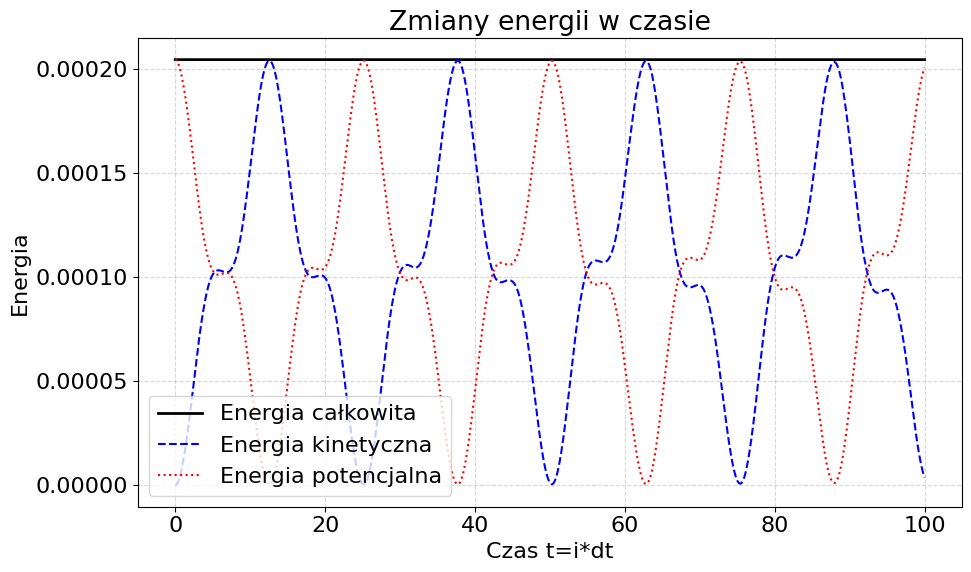

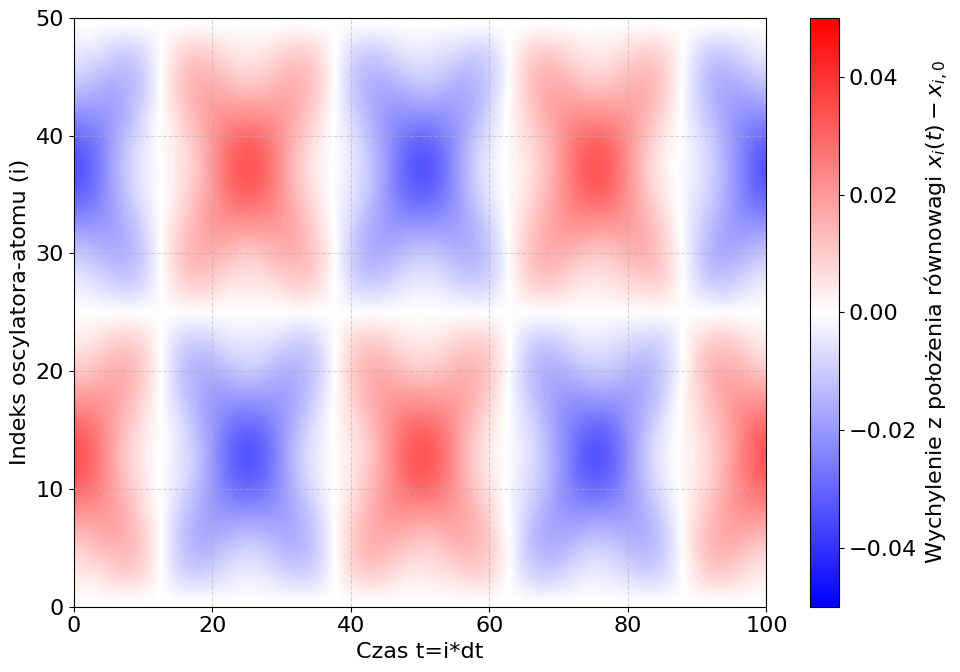

In [24]:
solve_atomic_chain()

--- Symulacja: Model Kuramoto ---


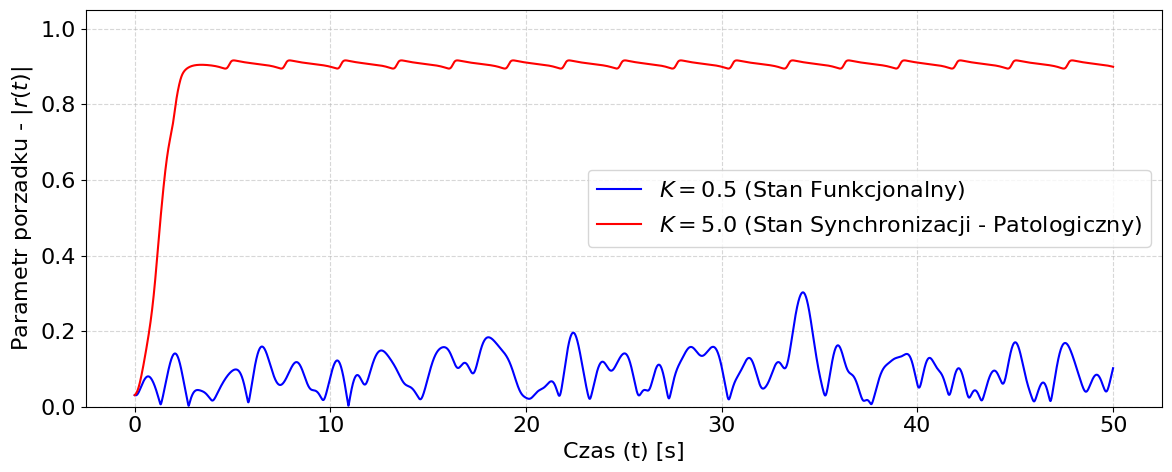

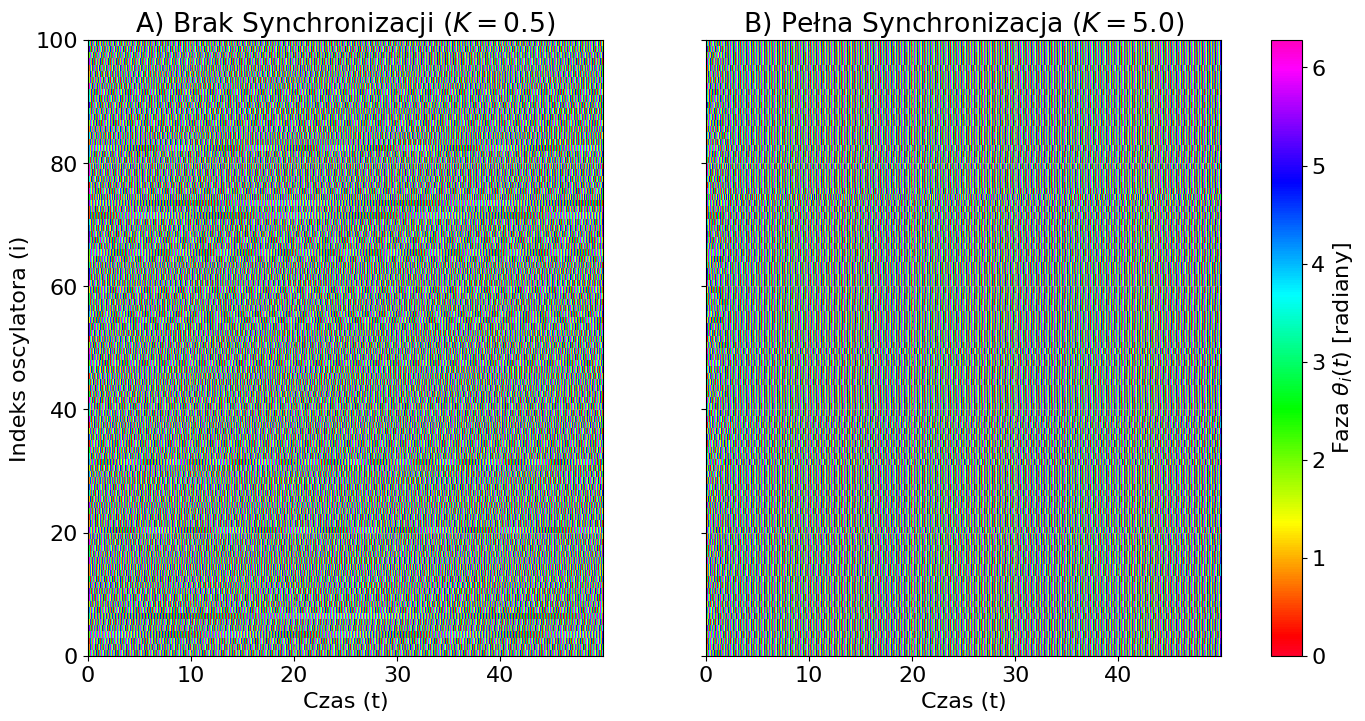

In [19]:
solve_kuramoto()